In [42]:
import cv2
import os
import time
import uuid #provides a way to generate and manipulate UUIDs (Universally Unique Identifiers)UUIDs are 128-bit values that are unique

In [43]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [44]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [45]:
train_images = tf.data.Dataset.list_files('/kaggle/input//faceddd/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [46]:
test_images = tf.data.Dataset.list_files('/kaggle/input//faceddd/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [47]:
val_images = tf.data.Dataset.list_files('/kaggle/input//faceddd/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [48]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [49]:
train_labels = tf.data.Dataset.list_files('/kaggle/input//faceddd/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [50]:
test_labels = tf.data.Dataset.list_files('/kaggle/input//faceddd/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
val_labels = tf.data.Dataset.list_files('/kaggle/input//faceddd/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(2880, 2880, 660, 660, 600, 600)

In [53]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [54]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [55]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [56]:
data_samples = train.as_numpy_iterator()

In [57]:
res = data_samples.next()

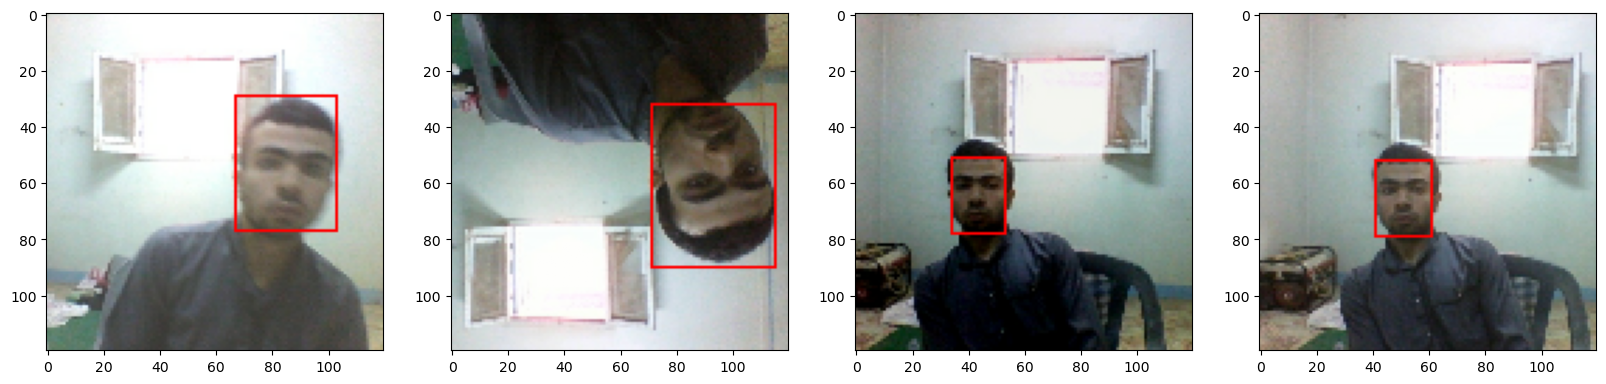

In [58]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0),1)

    ax[idx].imshow(sample_image)

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [60]:
vgg = VGG16(include_top=False)

In [61]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [62]:
facetracker = build_model()

In [63]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [64]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay,)

In [65]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return  delta_size+delta_coord

In [66]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [67]:
class FaceTracker(Model): 
    
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [68]:
model = FaceTracker(facetracker)

In [69]:
model.compile(opt, classloss, regressloss)

In [70]:
hist = model.fit(train, epochs=27, validation_data=val)

Epoch 1/27
360/360 [==============================] - 21s 37ms/step - total_loss: 0.3070 - class_loss: 0.0709 - regress_loss: 0.2716 - val_total_loss: 0.0739 - val_class_loss: 4.0020e-05 - val_regress_loss: 0.0739
Epoch 2/27
360/360 [==============================] - 20s 36ms/step - total_loss: 0.0918 - class_loss: 0.0198 - regress_loss: 0.0819 - val_total_loss: 0.0504 - val_class_loss: 4.7799e-05 - val_regress_loss: 0.0504
Epoch 3/27
360/360 [==============================] - 19s 36ms/step - total_loss: 0.0535 - class_loss: 0.0093 - regress_loss: 0.0489 - val_total_loss: 0.0117 - val_class_loss: 1.4151e-04 - val_regress_loss: 0.0116
Epoch 4/27
360/360 [==============================] - 19s 36ms/step - total_loss: 0.0337 - class_loss: 0.0049 - regress_loss: 0.0312 - val_total_loss: 0.0313 - val_class_loss: 0.0021 - val_regress_loss: 0.0303
Epoch 5/27
360/360 [==============================] - 19s 36ms/step - total_loss: 0.0322 - class_loss: 0.0057 - regress_loss: 0.0294 - val_total_los

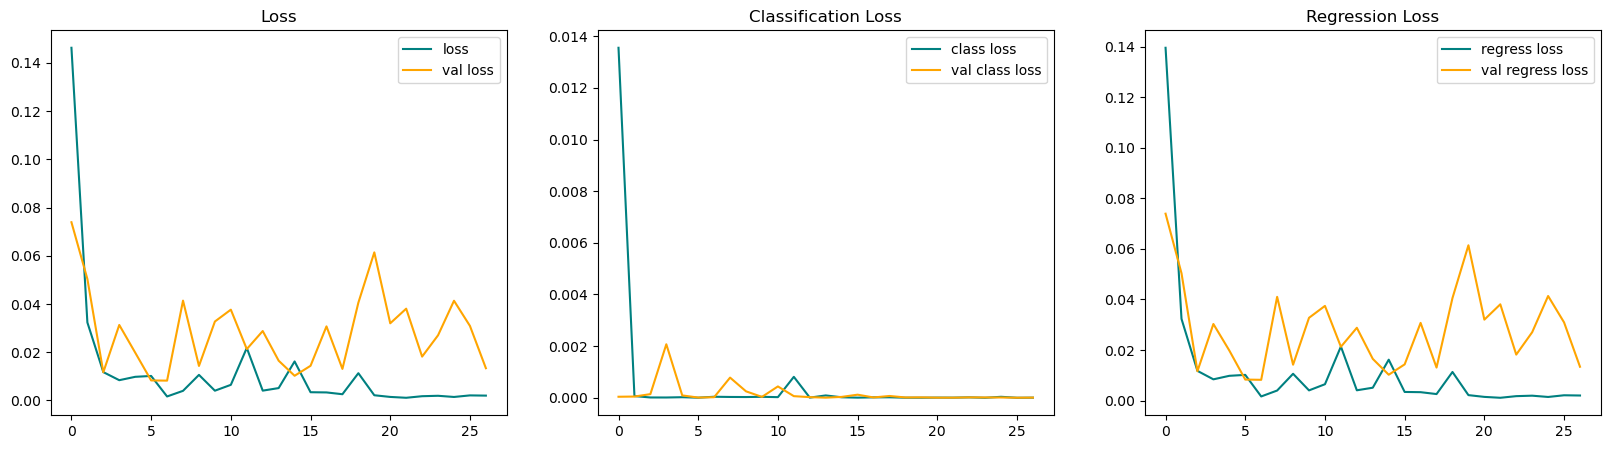

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [72]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 176ms/step


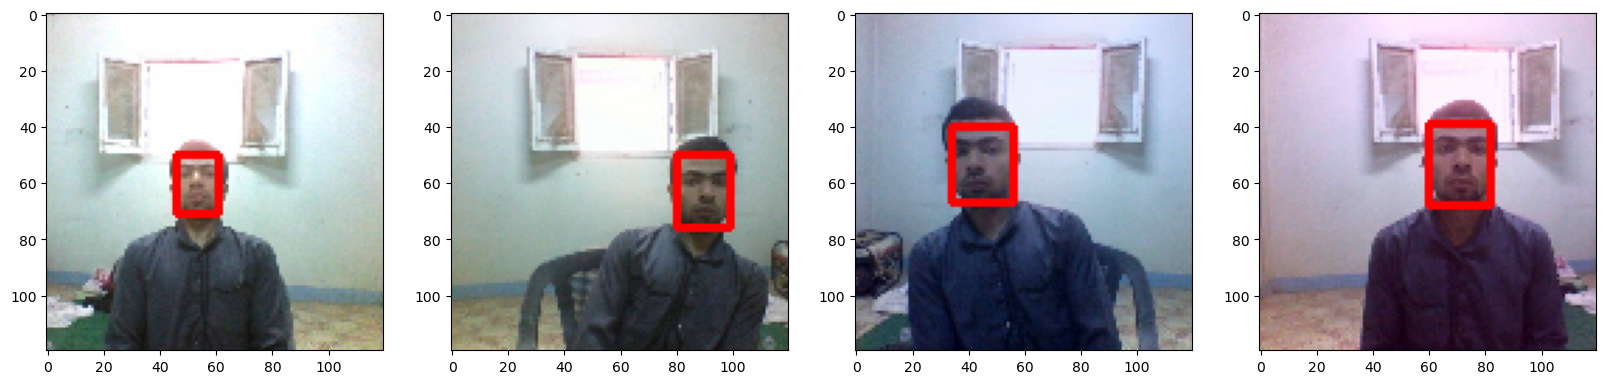

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [74]:
from tensorflow.keras.models import load_model

In [76]:
facetracker.save('facetracker.h5')